In [22]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy
from torch.optim import SGD
import matplotlib.pyplot as plt
import seaborn as sns

from pacmagic.visualizing.model_plots import plot_calibration_curve
from utils import MCDropout, train
from sklearn.metrics import roc_auc_score

In [2]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [3]:
quantile = [y_train.mean().item()]

model = MCDropout(X_train.shape[1], 1, (64,), class_weights=[quantile[0], 1 - quantile[0]])

In [4]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

In [5]:
data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [6]:
# optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [7]:
train(model, data, target, data_val, target_val, optimizer, quantile)

Validation loss: 0.11, Train loss: 0.11
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05


MCDropout(
  (f): Sequential(
    (0): Linear(in_features=44, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
  (nll): BCEWithLogitsLoss()
)

In [8]:
with torch.no_grad():
    model.train()
    outputs = torch.sigmoid(torch.stack([model(data_val)[0] for _ in range(512)])).squeeze(-1)

In [9]:
probs = outputs.mean(0).numpy()
stds = outputs.std(0).numpy()

In [10]:
outputs.shape

torch.Size([512, 4477])

In [11]:
stds.shape

(4477,)

In [12]:
outputs[:, stds.argmax()].std()

tensor(0.2183)

In [13]:
cutoff = np.percentile(probs, 100 * (1-y_train.values.mean()))

preds = probs > cutoff

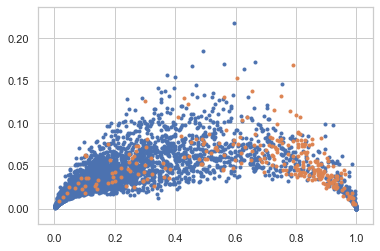

In [14]:
plt.scatter(probs[preds == y_test.squeeze().values], stds[preds == y_test.squeeze().values], marker='.')
plt.scatter(probs[preds != y_test.squeeze().values], stds[preds != y_test.squeeze().values], marker='.')

In [15]:
y_true = y_test.squeeze().values

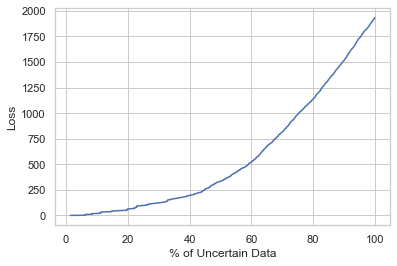

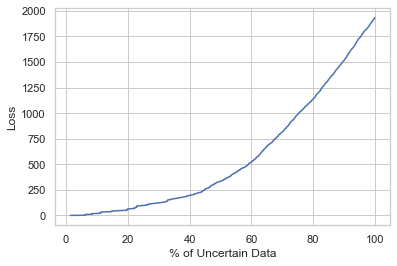

In [16]:
make_performance_uncertainty_plot(y_true, probs, stds, 'Loss', performance_fn_args={'reduction': 'sum'})

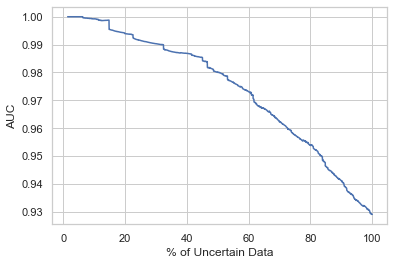

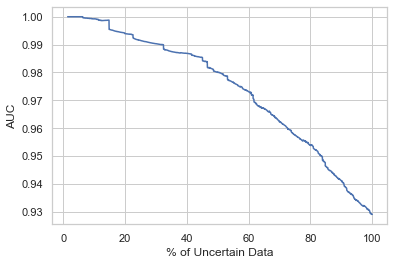

In [23]:
make_performance_uncertainty_plot(y_true, probs, stds, 'AUC', performance_fn=roc_auc_score)

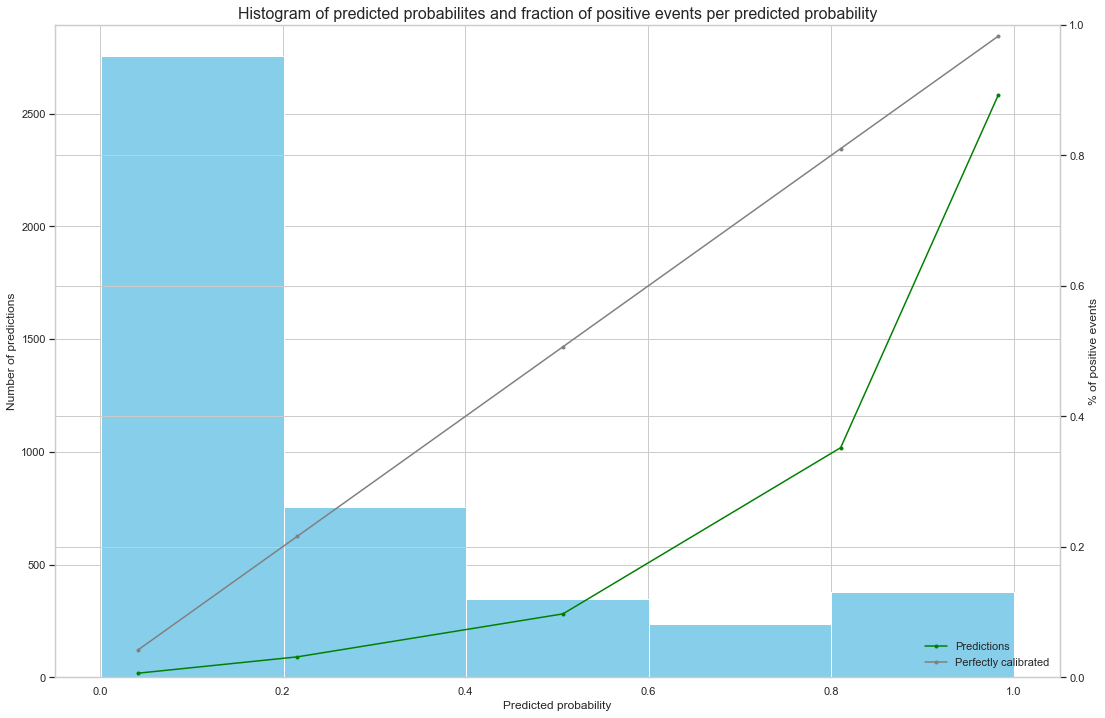

In [17]:
plot_calibration_curve(y_true, probs)

In [18]:
# loss at 100%
cross_entropy(y_true, probs, reduction='sum')

1933.2631844333614

In [19]:
# loss at 50%

y_50 = y_true[stds.argsort()[:int(0.5 * len(stds))]]
y_prob_50 = probs[stds.argsort()[:int(0.5 * len(stds))]]

In [20]:
cross_entropy(y_50, y_prob_50, reduction='sum')

334.30690289244603